# Sampling Profiles at Fire Locations

In [32]:
import numpy  as np

import matplotlib.pyplot as plt

from pyobs import vx14  as vx
from pyobs import csBin as cs
import xarray as xr

%matplotlib inline

## Range of Dates in 2020

In [33]:
vxd14_root = '/nfs3m/css/curated01/viirs/data/data/Level2/VJ114IMG/2020/'
d1, d2 = (214,306) # Aug 1 thru Oct 31

## Testing VIIRS ingest

[] Total number of fires: 85785


([<matplotlib.lines.Line2D at 0x2b3e4be25ee0>], None)

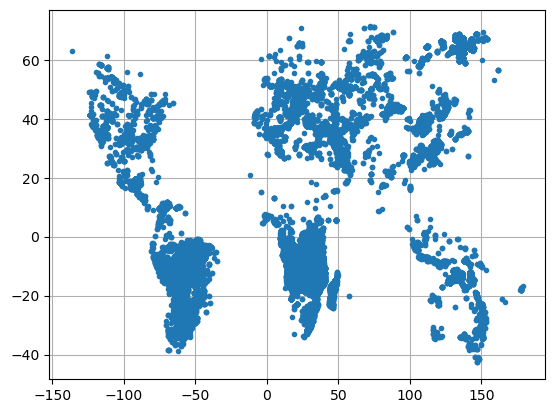

In [34]:
fvx =  vx.VX14(vxd14_root+'/%03d'%d1+'/*.nc',verbose=True)
plt.plot(fvx.ds.FP_longitude,fvx.ds.FP_latitude,'.'),plt.grid()

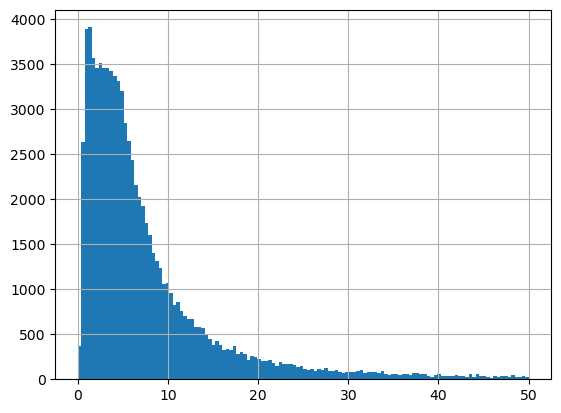

In [35]:
_ = plt.hist(fvx.ds.FP_power,128,range=(0,50)),plt.grid()

## Instatiate CS binning

In [36]:
# NetCDF filenwith cubed sphere coordinates
dyv2_dn  = '/css/g5nr/DYAMONDv2/'   # DYAMOND v2, 3km files on discover
const_fn = dyv2_dn + '03KM/DYAMONDv2_c2880_L181/const_2d_asm_Mx/202002/DYAMONDv2_c2880_L181.const_2d_asm_Mx.20200201_0000z.nc4'

In [37]:
# Construct the object by filename
csbin = cs.CSBIN(filename=const_fn)
%time csbin.set_Indices(fvx.ds.FP_longitude, fvx.ds.FP_latitude)

CPU times: user 19.5 ms, sys: 653 µs, total: 20.2 ms
Wall time: 21.5 ms


In [38]:
# Construct the object by Xdim
csbin = cs.CSBIN(Xdim = 2880)
%time csbin.set_Indices(fvx.ds.FP_longitude, fvx.ds.FP_latitude)

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 21.5 ms


In [39]:
# Use the function binObs
csfvx = csbin.binObs(fvx.ds.FP_power.to_numpy())

In [40]:
# for testing
ds = xr.open_dataset(const_fn)
Xdim = ds.dims['Xdim']

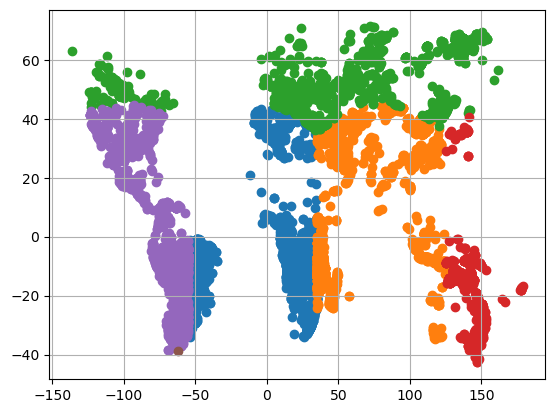

In [41]:
# Scatter fvx face by face
lon_c = ds['lons']
lat_c = ds['lats']
for f in range (6):
    ij = csfvx[f].ravel() <1.e14
    lon0 = lon_c[f].data.ravel()[ij]
    lat0 = lat_c[f].data.ravel()[ij]
    lon0 = np.where(lon0 >180,lon0-360, lon0)
    plt.scatter(lon0, lat0)
    
plt.grid()

In [42]:
# test 1
# randomly pick a subset of each face, bin it and do the comparison

# For each face
# -------------

for f in range(6):
  #randomly pick for each face
  K = np.random.permutation(Xdim*Xdim)[:Xdim] # small random set
    
  # Flatten subset of obs and coordinates at this face
  # -------------------------------------------------- 
  lons_ = np.ravel(ds['lons'][f])[K]
  lats_ = np.ravel(ds['lats'][f])[K]
  obs_  = np.ravel(ds['PHIS'][0,f])[K]
    
  # Next bin the subset of observations
  # -----------------------------------
  csbin.set_Indices(lons_, lats_)
  obs__ = csbin.binObs(obs_)[f].ravel()[K]
  
  # Compare binned and expected values
  # ----------------------------------
  err = abs(obs_ - obs__)
  print('---- Face ',f)
  if (err < 10**(-5)).all() :
     print("face {} is good".format(f),err.max())
  else:
     print("face {} is BAD".format(f),err.max())

---- Face  0
face 0 is good 0.0
---- Face  1
face 1 is good 0.0
---- Face  2
face 2 is good 0.0
---- Face  3
face 3 is good 0.0
---- Face  4
face 4 is good 0.0
---- Face  5
face 5 is good 0.0


In [43]:
# test 2
# concatenate the observations on the same locations, bin it and do the comparison

for f in range(6):
  K = np.random.permutation(Xdim*Xdim)[:Xdim]
  lons_ = np.ravel(ds['lons'][f])[K]
  lats_ = np.ravel(ds['lats'][f])[K]
  obs0  = np.ravel(ds['PHIS'][0,f])[K]
      
  lons_ = np.concatenate((lons_,lons_))
  lats_ = np.concatenate((lats_,lats_))
  obs_  = np.concatenate((obs0, 0.5*obs0))

  # Next bin the subset of observations
  # -----------------------------------
  csbin.set_Indices(lons_, lats_)
  obs__ = csbin.binObs(obs_)[f].ravel()[K]
   
  # Compare binned and expected values
  # ----------------------------------
  err = abs(obs0*0.75 - obs__)
  print('---- Face ',f)
  if (err < 10**(-2)).all() :
     print("face {} is good".format(f),err.max())
  else:
     print("face {} is BAD".format(f),err.max())


---- Face  0
face 0 is good 0.0009765625
---- Face  1
face 1 is good 0.001953125
---- Face  2
face 2 is good 0.0009765625
---- Face  3
face 3 is good 0.0009765625
---- Face  4
face 4 is good 0.0009765625
---- Face  5
face 5 is good 0.0009765625
